In [1]:
# geolocation
# products
# sellers
# category_translations

In [30]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score, calinski_harabasz_score

from yellowbrick.cluster import KElbowVisualizer #kmeans

In [3]:
customers = pd.read_csv('../CSV-Excels/P5_datasets/olist_customers_dataset.csv')
geolocation = pd.read_csv('../CSV-Excels/P5_datasets/olist_geolocation_dataset.csv')
item_orders = pd.read_csv('../CSV-Excels/P5_datasets/olist_order_items_dataset.csv')
order_payments = pd.read_csv('../CSV-Excels/P5_datasets/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('../CSV-Excels/P5_datasets/olist_order_reviews_dataset.csv')
orders = pd.read_csv('../CSV-Excels/P5_datasets/olist_orders_dataset.csv')
products = pd.read_csv('../CSV-Excels/P5_datasets/olist_products_dataset.csv')
sellers = pd.read_csv('../CSV-Excels/P5_datasets/olist_sellers_dataset.csv')
category_translations = pd.read_csv('../CSV-Excels/P5_datasets/product_category_name_translation.csv')

In [4]:
customers
customers.describe(include='all')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,99441,99441,99441.000000,99441,99441
unique,99441,96096,NaN,4119,27
top,06b8999e2fba1a1fbc88172c00ba8bc7,8d50f5eadf50201ccdcedfb9e2ac8455,NaN,sao paulo,SP
freq,1,17,NaN,15540,41746
mean,NaN,NaN,35137.474583,NaN,NaN
std,NaN,NaN,29797.938996,NaN,NaN
min,NaN,NaN,1003.000000,NaN,NaN
25%,NaN,NaN,11347.000000,NaN,NaN
50%,NaN,NaN,24416.000000,NaN,NaN
75%,NaN,NaN,58900.000000,NaN,NaN


In [5]:
customer_ids = customers[["customer_id", "customer_unique_id"]]
customer_ids

,customer_id,customer_unique_id
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066
...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e


In [6]:
orders
orders.describe(include='all')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2018-04-11 10:48:14,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-08 23:38:46,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


In [7]:
orders_date_with_customer_id = orders[["customer_id", "order_id", "order_purchase_timestamp"]]
orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
orders_date_with_customer_id = orders_date_with_customer_id.merge(how='left', on='customer_id', right=customer_ids)

/tmp/ipykernel_58641/15476665.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])


In [8]:
orders_date_with_customer_id.describe(include='all')

/tmp/ipykernel_58641/904184309.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  orders_date_with_customer_id.describe(include='all')


,customer_id,order_id,order_purchase_timestamp,customer_unique_id
count,99441,99441,99441,99441
unique,99441,99441,98875,96096
top,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2018-04-11 10:48:14,8d50f5eadf50201ccdcedfb9e2ac8455
freq,1,1,3,17
first,NaN,NaN,2016-09-04 21:15:19,NaN
last,NaN,NaN,2018-10-17 17:30:18,NaN


In [9]:
# ajouter la colonne jours depuis dernier achat
orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
orders_date_with_customer_id['days_since_last_purchase'] = (
    orders_date_with_customer_id['order_purchase_timestamp'].max() - orders_date_with_customer_id['order_purchase_timestamp']
).dt.days

In [10]:
# ajouter la colonne achat pour la période de Noel
orders_date_with_customer_id['christmas_purchase'] = orders_date_with_customer_id['order_purchase_timestamp'].apply(
    lambda x: 1 if ((x.strftime("%m/%d") > "11/01") & (x.strftime("%m/%d") < "12/25")) else 0)

In [11]:
orders_date_with_customer_id

,customer_id,order_id,order_purchase_timestamp,customer_unique_id,days_since_last_purchase,christmas_purchase
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,380,0
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,84,0
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,70,0
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,332,1
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,245,0
...,...,...,...,...,...,...
99436,39bd1228ee8140590ac3aca26f2dfe00,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,587,0
99437,1fca14ff2861355f6e5f14306ff977a7,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,da62f9e57a76d978d02ab5362c509660,253,0
99438,1aa71eb042121263aafbe80c1b562c9c,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,737520a9aad80b3fbbdad19b66b37b30,416,0
99439,b331b74b18dc79bcdf6532d51e1637c1,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,5097a5312c8b157bb7be58ae360ef43c,281,0


In [12]:
item_orders
item_orders.describe(include='all')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
count,112650,112650.000000,112650,112650,112650,112650.000000,112650.000000
unique,98666,NaN,32951,3095,93318,NaN,NaN
top,8272b63d03f5f79c56e9e4120aec44ef,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2017-07-21 18:25:23,NaN,NaN
freq,21,NaN,527,2033,21,NaN,NaN
mean,NaN,1.197834,NaN,NaN,NaN,120.653739,19.990320
std,NaN,0.705124,NaN,NaN,NaN,183.633928,15.806405
min,NaN,1.000000,NaN,NaN,NaN,0.850000,0.000000
25%,NaN,1.000000,NaN,NaN,NaN,39.900000,13.080000
50%,NaN,1.000000,NaN,NaN,NaN,74.990000,16.260000
75%,NaN,1.000000,NaN,NaN,NaN,134.900000,21.150000


In [13]:
# savoir combien d'articles sont achetés :
# supprimer les lignes de même commande pour que order_item_id 
# corresponde au nb de produits achetés lors de la commande

nb_items_bought = item_orders[["order_id", "order_item_id"]]
nb_items_bought.drop_duplicates(subset=['order_id'], keep='last', inplace=True, ignore_index=True)

/home/kilian/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [14]:
df = orders_date_with_customer_id.merge(how='left', on='order_id', right=nb_items_bought)

In [15]:
df

,customer_id,order_id,order_purchase_timestamp,customer_unique_id,days_since_last_purchase,christmas_purchase,order_item_id
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,380,0,1.0
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,84,0,1.0
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,70,0,1.0
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,332,1,1.0
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,245,0,1.0
...,...,...,...,...,...,...,...
99436,39bd1228ee8140590ac3aca26f2dfe00,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,587,0,1.0
99437,1fca14ff2861355f6e5f14306ff977a7,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,da62f9e57a76d978d02ab5362c509660,253,0,1.0
99438,1aa71eb042121263aafbe80c1b562c9c,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,737520a9aad80b3fbbdad19b66b37b30,416,0,1.0
99439,b331b74b18dc79bcdf6532d51e1637c1,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,5097a5312c8b157bb7be58ae360ef43c,281,0,2.0


In [16]:
order_reviews
order_reviews.describe(include='all')

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
count,99224,99224,99224.000000,11568,40977,99224,99224
unique,98410,98673,NaN,4527,36159,636,98248
top,7b606b0d57b078384f0b58eac1d41d78,c88b1d1b157a9999ce368f218a407141,NaN,Recomendo,Muito bom,2017-12-19 00:00:00,2017-06-15 23:21:05
freq,3,3,NaN,423,230,463,4
mean,NaN,NaN,4.086421,NaN,NaN,NaN,NaN
std,NaN,NaN,1.347579,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,4.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,5.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,5.000000,NaN,NaN,NaN,NaN


In [17]:
order_score = order_reviews[["order_id", "review_score"]]
order_score 

,order_id,review_score
0,73fc7af87114b39712e6da79b0a377eb,4
1,a548910a1c6147796b98fdf73dbeba33,5
2,f9e4b658b201a9f2ecdecbb34bed034b,5
3,658677c97b385a9be170737859d3511b,5
4,8e6bfb81e283fa7e4f11123a3fb894f1,5
...,...,...
99219,2a8c23fee101d4d5662fa670396eb8da,5
99220,22ec9f0669f784db00fa86d035cf8602,5
99221,55d4004744368f5571d1f590031933e4,5
99222,7725825d039fc1f0ceb7635e3f7d9206,4


In [18]:
df = df.merge(how='left', on='order_id', right=order_score)
df

,customer_id,order_id,order_purchase_timestamp,customer_unique_id,days_since_last_purchase,christmas_purchase,order_item_id,review_score
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,380,0,1.0,4.0
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,84,0,1.0,4.0
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,70,0,1.0,5.0
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,332,1,1.0,5.0
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,245,0,1.0,5.0
...,...,...,...,...,...,...,...,...
99987,39bd1228ee8140590ac3aca26f2dfe00,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,587,0,1.0,5.0
99988,1fca14ff2861355f6e5f14306ff977a7,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,da62f9e57a76d978d02ab5362c509660,253,0,1.0,4.0
99989,1aa71eb042121263aafbe80c1b562c9c,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,737520a9aad80b3fbbdad19b66b37b30,416,0,1.0,5.0
99990,b331b74b18dc79bcdf6532d51e1637c1,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,5097a5312c8b157bb7be58ae360ef43c,281,0,2.0,2.0


In [19]:
order_payments
order_payments.describe(include='all')

,order_id,payment_sequential,payment_type,payment_installments,payment_value
count,103886,103886.000000,103886,103886.000000,103886.000000
unique,99440,NaN,5,NaN,NaN
top,fa65dad1b0e818e3ccc5cb0e39231352,NaN,credit_card,NaN,NaN
freq,29,NaN,76795,NaN,NaN
mean,NaN,1.092679,NaN,2.853349,154.100380
std,NaN,0.706584,NaN,2.687051,217.494064
min,NaN,1.000000,NaN,0.000000,0.000000
25%,NaN,1.000000,NaN,1.000000,56.790000
50%,NaN,1.000000,NaN,1.000000,100.000000
75%,NaN,1.000000,NaN,4.000000,171.837500


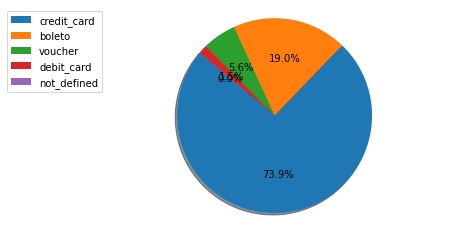

In [20]:
payment_types = order_payments.payment_type.value_counts()
labels = payment_types.index
sizes = payment_types.values

# Plot the pie chart
plt.pie(sizes,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.legend(labels,bbox_to_anchor=(0, 1))
plt.show()

In [21]:
payments = order_payments[["order_id", "payment_installments", "payment_value"]]
payments

,order_id,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,2,128.45
...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,363.31
103882,7b905861d7c825891d6347454ea7863f,2,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,47.77
103884,b8b61059626efa996a60be9bb9320e10,5,369.54


In [22]:
df = df.merge(how='left', on='order_id', right=payments)

In [23]:
df

,customer_id,order_id,order_purchase_timestamp,customer_unique_id,days_since_last_purchase,christmas_purchase,order_item_id,review_score,payment_installments,payment_value
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,380,0,1.0,4.0,1.0,18.12
1,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,380,0,1.0,4.0,1.0,2.00
2,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,380,0,1.0,4.0,1.0,18.59
3,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,84,0,1.0,4.0,1.0,141.46
4,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,70,0,1.0,5.0,3.0,179.12
...,...,...,...,...,...,...,...,...,...,...
104473,39bd1228ee8140590ac3aca26f2dfe00,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,587,0,1.0,5.0,3.0,85.08
104474,1fca14ff2861355f6e5f14306ff977a7,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,da62f9e57a76d978d02ab5362c509660,253,0,1.0,4.0,3.0,195.00
104475,1aa71eb042121263aafbe80c1b562c9c,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,737520a9aad80b3fbbdad19b66b37b30,416,0,1.0,5.0,5.0,271.01
104476,b331b74b18dc79bcdf6532d51e1637c1,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,5097a5312c8b157bb7be58ae360ef43c,281,0,2.0,2.0,4.0,441.16


In [24]:
number_of_purchase = df.groupby('customer_unique_id').size()

data = df.groupby('customer_unique_id').mean()

data['number_of_purchase'] = number_of_purchase

data.rename(columns={'order_item_id':'number_of_products_bought'}, inplace=True)

data.isnull().sum()
data = data[(~data['payment_value'].isna()) & (data['payment_value'] != 0)]
data.fillna(data.mean(), inplace=True)

In [25]:
data.describe(include='all')

,days_since_last_purchase,christmas_purchase,number_of_products_bought,review_score,payment_installments,payment_value,number_of_purchase
count,96093.000000,96093.000000,96093.000000,96093.000000,96093.000000,96093.000000,96093.000000
mean,289.102337,0.123076,1.139099,4.085067,2.901509,158.717482,1.087228
std,153.128232,0.327104,0.525246,1.336532,2.677539,219.499964,0.493251
min,0.000000,0.000000,1.000000,1.000000,0.000000,1.856818,1.000000
25%,165.000000,0.000000,1.000000,4.000000,1.000000,60.850000,1.000000
50%,271.000000,0.000000,1.000000,5.000000,2.000000,103.750000,1.000000
75%,398.000000,0.000000,1.000000,5.000000,4.000000,175.090000,1.000000
max,772.000000,1.000000,21.000000,5.000000,24.000000,13664.080000,33.000000


In [26]:
def create_final_df(customers, orders, item_orders, order_reviews, payments, scaler, date):
    customer_ids = customers[["customer_id", "customer_unique_id"]]
    orders_date_with_customer_id = orders[["customer_id", "order_id", "order_purchase_timestamp"]]
    orders_date_with_customer_id['order_purchase_timestamp'] = pd.to_datetime(orders_date_with_customer_id['order_purchase_timestamp'])
    orders_date_with_customer_id = orders_date_with_customer_id.merge(how='left', on='customer_id', right=customer_ids)
    orders_limited_date = orders_date_with_customer_id[orders_date_with_customer_id['order_purchase_timestamp'] <= date]
    orders_limited_date['days_since_last_purchase'] = (
    orders_limited_date['order_purchase_timestamp'].max() - orders_limited_date['order_purchase_timestamp']
    ).dt.days
    orders_limited_date['christmas_purchase'] = orders_limited_date['order_purchase_timestamp'].apply(
    lambda x: 1 if ((x.strftime("%m/%d") > "11/01") & (x.strftime("%m/%d") < "12/25")) else 0)
    nb_items_bought = item_orders[["order_id", "order_item_id"]]
    nb_items_bought.drop_duplicates(subset=['order_id'], keep='last', inplace=True, ignore_index=True)
    df = orders_limited_date.merge(how='left', on='order_id', right=nb_items_bought)
    order_score = order_reviews[["order_id", "review_score"]]
    df = df.merge(how='left', on='order_id', right=order_score)
    payments = order_payments[["order_id", "payment_installments", "payment_value"]]
    df = df.merge(how='left', on='order_id', right=payments)
    number_of_purchase = df.groupby('customer_unique_id').size()
    data = df.groupby('customer_unique_id').mean()
    data['number_of_purchase'] = number_of_purchase
    data.rename(columns={'order_item_id':'number_of_products_bought'}, inplace=True)
    data = data[data['payment_installments'] > 0]
    data = data[(~data['payment_value'].isna()) & (data['payment_value'] != 0)]
    data.fillna(data.mean(), inplace=True)
    data["payment_installments"] = np.log10(data['payment_installments'].values)
    data["payment_value"] = np.log10(data['payment_value'].values)
    data_scaled = pd.DataFrame(scaler.fit_transform(data),
                        columns=data.columns)
    return data_scaled

# Analyse exploratoire -> graphiques

Text(0.5, 1.0, 'Distribution de la variable review_score')

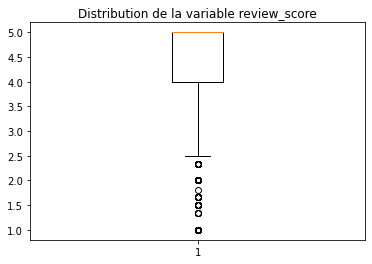

In [57]:
# boite à moustache review score
plt.boxplot(data.review_score)
plt.title('Distribution de la variable review_score')

Text(0.5, 1.0, 'Distribution de la variable payment_value')

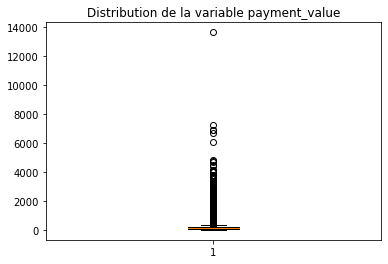

In [58]:
# boite à moustache payment_value
plt.boxplot(data.payment_value)
plt.title('Distribution de la variable payment_value')

Text(0.5, 1.0, 'Distribution de la variable payment_installments')

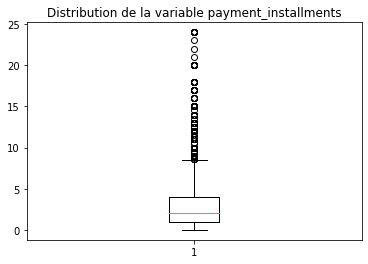

In [59]:
# boite à moustache payment_installments
plt.boxplot(data.payment_installments)
plt.title('Distribution de la variable payment_installments')

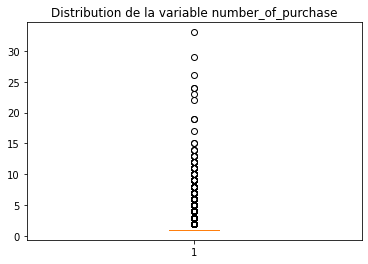

1     90285
2      4569
3       740
4       256
5        82
6        63
7        31
8        13
9        12
10        8
11        7
12        6
13        4
14        3
15        2
24        2
19        2
22        1
26        1
29        1
17        1
33        1
23        1
Name: number_of_purchase, dtype: int64

In [67]:
# boite à moustache number_of_purchase
plt.boxplot(data.number_of_purchase)
plt.title('Distribution de la variable number_of_purchase')
plt.show()
data.number_of_purchase.value_counts()